# Análisis Encuesta Origen-Destino -  Limpieza de Datos & Cálculo de Indicadores

## Uruguay - Montevideo - 2009

#### Elaborado por Paula Vásquez-Henríquez, Ariel López, Genaro Cuadros, Exequiel Gaete, Alba Vásquez y Juan Correa

In [ ]:
!pip3 uninstall matplotlib -y

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:35
🔁 Restarting kernel...


In [ ]:
!git clone https://github.com/zorzalerrante/aves.git aves_git

Cloning into 'aves_git'...
remote: Enumerating objects: 832, done.
remote: Counting objects: 100% (463/463), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 832 (delta 200), reused 435 (delta 183), pack-reused 369
Receiving objects: 100% (832/832), 165.53 MiB | 26.90 MiB/s, done.
Resolving deltas: 100% (323/323), done.
Checking out files: 100% (280/280), done.


In [ ]:
!mamba env update --name base --file aves_git/environment-colab.yml

pkgs/r/linux-64          [] (00m:00s) 
pkgs/r/linux-64          [] (00m:00s) 404 KB / ?? (1.31 MB/s)
pkgs/r/linux-64          [] (00m:00s) 404 KB / ?? (1.31 MB/s)
conda-forge/linux-64     [] (00m:00s) 
pkgs/r/linux-64          [] (00m:00s) 404 KB / ?? (1.31 MB/s)
conda-forge/linux-64     [] (00m:00s) 241 KB / ?? (793.99 KB/s)
pkgs/r/linux-64          [] (00m:00s) 404 KB / ?? (1.31 MB/s)
conda-forge/linux-64     [] (00m:00s) 241 KB / ?? (793.99 KB/s)
conda-forge/noarch       [] (00m:00s) 
pkgs/r/linux-64          [] (00m:00s) 404 KB / ?? (1.31 MB/s)
conda-forge/linux-64     [] (00m:00s) 241 KB / ?? (793.99 KB/s)
conda-forge/noarch       [] (00m:00s) 343 KB / ?? (1.11 MB/s)
pkgs/r/linux-64          [] (00m:00s) 404 KB / ?? (1.31 MB/s)
conda-forge/linux-64     [] (00m:00s) 241 KB / ?? (793.99 KB/s)
conda-forge/noarch       [] (00m:00s) 343 KB / ?? (1.11 MB/s)
pkgs/main/linux-64       [] (00m:00s) 
pkgs/r/linux-64          [] (00m:00s) 404 KB / ?? (1.31 MB/s)
conda-forge/linux-64     [] (0

In [ ]:
!pip3 install geopandas
!pip3 install pandasql
!pip3 install seaborn

     |████████████████████████████████| 1.6 MB 6.6 MB/s 
     |████████████████████████████████| 150 kB 43.3 MB/s 
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26818 sha256=5b3873cc1a4e2f0ae25b5819443dd16db91026ef43122934500799f69336c9dc
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import warnings
import shapely
from sklearn.preprocessing import normalize
import datetime

In [ ]:
def decode_column(df, fname, col_name, index_col='id', value_col=None, sep=';', encoding='utf-8'):
    '''
    param :df: DataFrame del que leeremos una columna.
    param :fname: nombre del archivo que contiene los valores a decodificar.
    param :col_name: nombre de la columna que queremos decodificar.
    param :index_col: nombre de la columna en el archivo @fname que tiene los índices que codifican @col_name
    param :value_col: nombre de la columna en el archivo @fname que tiene los valores decodificados
    param :sep: carácter que separa los valores en @fname. 
    param :encoding: identificación del _character set_ que utiliza el archivo. Usualmente es utf-8, si no funciona,
                     se puede probar con iso-8859-1.
    '''
    if value_col is None:
        value_col = 'value'
        
    values_df = pd.read_csv(fname, sep=sep, index_col=index_col, names=[index_col, value_col], header=0,
                            dtype={index_col: np.float64}, encoding=encoding)
    
    src_df = df.loc[:,(col_name,)]
    
    return src_df.join(values_df, on=col_name)[value_col]

In [ ]:
def convert_datatype(df, lista_columnas):
    for column in lista_columnas:
        df[column] = df[column].str.replace(",", ".").astype(float)
    return df

In [ ]:
def imputar_coordenadas_centroide_zat(df, latitud, longitud, zat, zat_shp):
    mask = df[latitud].isnull() | df[longitud].isnull()
    ids_latitud_vacia = df[mask].index
    working_df = pd.merge(df, city_shp[[zat_shp, 'x_coord', 'y_coord']], left_on=zat, right_on=zat_shp, how='left')
    df.loc[ids_latitud_vacia, latitud] = working_df.loc[ids_latitud_vacia, 'x_coord']
    df.loc[ids_latitud_vacia, longitud] = working_df.loc[ids_latitud_vacia, 'y_coord']
    return df

In [ ]:
def mapear_binarias(row, column):
    if row[column] == 'N':
        return 'No'
    elif row[column] == 'S':
        return 'Si'
    else:
        return 'Sin dato'

In [ ]:
def mapear_vacios(row, column):
    if pd.isna(row[column])==True:
        return 'Sin información'
    else:
        return row[column]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Caracterización de los datos

Los datos utilizados en este cuaderno corresponden a los resultados de la Encuesta Origen-Destino de Montevideo, Uruguay del 2009. 
A partir de estos datos se calcularan indicadores en tres niveles: de Cantidad de Viajes, y de Tiempo de Viajes.

### Importando datos

En esta sección, importamos todos los datos necesarios para el cálculo de indicadores. 
Para el caso de Montevideo 2009, los archivos son de cs.

Cabe destacar que para esta EOD tenemos data a nivel de:
- Viajes
- Etapas
- Personas
- Hogares

In [ ]:
data_path = '/content/drive/MyDrive/Carpeta compartida (clon Teams)/Ciudades/Montevideo/csv'
#data_path = '/Users/pauvasquezh/Dropbox/Proyectos/eod_analysis/Carpeta compartida (clon Teams)/Montevideo/csv'

In [ ]:
# Matriz de viajes
data_viajes = pd.read_csv(data_path + '/Encuesta viajes.csv', sep=',', encoding='latin1')
#data_viajes = convert_datatype(data_viajes, ["LATITUD_ORIGEN", "LATITUD_DESTINO", "LONGITUD_ORIGEN", "LONGITUD_DESTINO", 'PONDERADOR_CALIBRADO_VIAJES', 'FE_TOTAL', 'FACTOR_AJUSTE_TRANSMILENIO', 'PONDERADOR_CALIBRADO'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (32,33,34,48,63,76) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Matriz de personas
data_personas = pd.read_csv(data_path + '/Encuesta personas.csv', sep=',', encoding='latin1')
data_personas.head(2)
#data_personas = convert_datatype(data_personas, ['PONDERADOR_CALIBRADO'])

,EncuestaPersona_id,EncuestaHogar_ID,zonaimm,ZatHogar,MZatHogar,DptoHogar,estrato,Anillo,Idpersonaech,PARENTESCO,FECHAVIAJES,LUGAR4MANANAENUM,zat4am,Edad,Edad052009,NacimientoAnio,sexo,TamanoHogar,PersonasenHogar,Vehiculosenhogar,TipousuarioModo,Preescolar,PrimariaComun,PrimariaEspecial,CicloBasicoLiceo,BachillerSecundario,BachillerTecnilogico,Tecnico,Profesorado,Universitario,Terciario,Posgrado,EstudioPrincipal,AsistenciaInstitutoEducativo,Jubilado,Pensionista,Rentista,Estudiante,QuehaceresEnCasa,¿Se movió?,Ponderacion
0,55,51,Oeste,81,9,1,1,Montevideo,2,2,24/08/2009 00:00:00.000000,1.0,81.0,31,31.0,1978,2,3 o 4 Personas,3,1,5.0,1.0,6.0,0.0,3.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,TEC ADMINISTRACION DE EMPRESAS,2.0,2.0,2.0,2.0,2.0,1.0,SI,233.358348
1,68,67,Este,82,9,1,2,Montevideo,1,1,NaN,1.0,82.0,71,71.0,1937,2,2 Personas,2,0,NaN,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,1.0,1.0,2.0,2.0,1.0,#N/D,227.738047


In [ ]:
# Matriz de encuestas
data_encuestas = pd.read_csv(data_path + '/Encuesta hogares.csv', sep=',', encoding='latin1')
data_encuestas.head(2)
#data_personas = convert_datatype(data_personas, ['PONDERADOR_CALIBRADO'])

,EncuestaHogar_id,DEPARTAMENTO,Estrato,IdTamanoHogar,TamanoHogar,Personas,PersonasMenor4,PersonasDesde4,Autos,Motos,Otros,Vehiculos,EspaciosEstacionamiento,AutoECH,MotoECH,ZonaIMM,Ponderacion
0,51,1,1,3,3 o 4 Personas,3,0,3,0,1,0,1,0,2,1,Oeste,233.358348
1,62,1,2,2,2 Personas,2,0,2,0,0,0,0,0,2,2,Oeste,146.764519


### Preparación de los datos

#### Viajes

En esta etapa nos enfocaremos en preparar los datos con respecto a viajes.
En particular, nos enfocamos en limpiar y estandarizar los datos para las columnas que son relevantes para el cálculo de indicadores.


In [ ]:
data_viajes.MEDIOTRANSPORTE = decode_column(data_viajes, data_path + '/data_dictionaries/modotransporte.csv', 'MEDIOTRANSPORTE')
data_viajes.MEDIOTRANSPORTE.unique()

array(['Automovil pasajero', 'Omnibus', 'Moto pasajero', 'A pie',
       'Bicicleta', 'Taxi', 'Moto conductor', 'Automovil conductor',
       'Bus escolar', 'Bus empresa', 'Traccion animal', 'Remis', 'Otro',
       'Ferrocarril'], dtype=object)

In [ ]:
publico_viaje = ['Omnibus','Remis', 'Ferrocarril']
privado_viaje = ['Automovil pasajero','Moto pasajero','A pie','Bicicleta', 'Taxi', 'Moto conductor', 'Automovil conductor',
       'Bus escolar', 'Bus empresa', 'Traccion animal']
peaton_viaje = ['A pie','Bicicleta','Traccion animal']
motorizado_viaje = ['Omnibus','Remis', 'Ferrocarril','Automovil pasajero','Moto pasajero','Taxi', 'Moto conductor', 'Automovil conductor','Bus escolar', 'Bus empresa']

In [ ]:
selected_columns = ['EncuestaViaje_id', 'EncuestaHogar_id', 'EncuestaPersona_id', 'zonaimm','INICIOHORA',
       'INICIOMINUTOS', 'LLEGADAHORA', 'LLEGADAMINUTOS','TiempoTotal','NombreActividadDestino','ZATO', 'ZATD', 'MEDIOTRANSPORTE',
                    'Ponderacion']
viajes_df = data_viajes[selected_columns]

In [ ]:
data_viajes.columns

Index(['EncuestaViaje_id', 'EncuestaHogar_id', 'EncuestaPersona_id', 'zonaimm',
       'NUMEROVIAJE', 'NUMEROVIAJESIGUIENTE', 'IdViajeSiguiente', 'INICIOHORA',
       'INICIOMINUTOS', 'LLEGADAHORA',
       ...
       'TamanoHogar', 'PersonasenHogar', 'AutosenHogar', 'MotosenHogar',
       'OtrosenHogar', 'VehiculosenHogar', 'Estrato', 'Ingreso Familiar',
       'Quintil ingresos', 'Ponderacion'],
      dtype='object', length=141)

In [ ]:
viajes_df['Quintil'] = data_viajes['Quintil ingresos']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
viajes_df['Quintil'] = decode_column(viajes_df, data_path + '/data_dictionaries/quintil.csv', 'Quintil')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
viajes_df.shape

(8508, 15)

In [ ]:
print('Contando valores nulos por atributo')
for column in selected_columns:
    print('{}: {}'.format(column, viajes_df[column].isna().sum()))

Contando valores nulos por atributo
EncuestaViaje_id: 0
EncuestaHogar_id: 0
EncuestaPersona_id: 0
zonaimm: 1954
INICIOHORA: 2
INICIOMINUTOS: 2
LLEGADAHORA: 2
LLEGADAMINUTOS: 2
TiempoTotal: 2
NombreActividadDestino: 2
ZATO: 10
ZATD: 0
MEDIOTRANSPORTE: 0
Ponderacion: 0


In [ ]:
# Llenado de coordenadas para datos vacíos, se imputará centroide del ZAT correspondiente.

In [ ]:
#viajes_df = imputar_coordenadas_centroide_zat(viajes_df, 'LATITUD_ORIGEN', 'LONGITUD_ORIGEN', 'ZAT_ORIGEN')
#viajes_df = imputar_coordenadas_centroide_zat(viajes_df, 'LATITUD_DESTINO', 'LONGITUD_DESTINO','ZAT_DESTINO')

In [ ]:
# Limpiando datos de variables binarias

In [ ]:
def pico_habil(row):
    if row['INICIOHORA'] >= 7.0 and row['INICIOHORA'] <= 9.0:
        return'Si'
    else:
        return 'No'
    
viajes_df['PICO_HABIL'] = viajes_df.apply(lambda row: pico_habil(row), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
mask = viajes_df['ZATO'].isnull() | viajes_df['ZATD'].isnull()
viajes_df = viajes_df[~mask]

In [ ]:
viajes_df['Intra_Inter'] = viajes_df.apply(lambda row: 'Intra' if row['ZATO'] == row['ZATD'] else 'Inter', axis=1)

In [ ]:
def publico_privado(row, column, publico, privado):
    if row[column] in (publico):
        return 'Público'
    elif row[column] in (privado):
        return 'Privado'
    else:
        return 'Otro'
    
viajes_df['publico_privado'] = viajes_df.apply(lambda row: publico_privado(row, 'MEDIOTRANSPORTE', publico_viaje, privado_viaje), axis=1)

In [ ]:
# Clasificando los viajes como motorizado o no motorizado según medio
def motorizado(row, column, no_motorizado, motorizado):
    if row[column] in (motorizado):
        return 'Motorizado'
    elif row[column] in (no_motorizado):
        return 'No Motorizado'
    else:
        return 'Otro'
    
viajes_df['motorizado'] = viajes_df.apply(lambda row: motorizado(row, 'MEDIOTRANSPORTE', peaton_viaje,motorizado_viaje), axis=1)

In [ ]:
viajes_df['duracion'] = (viajes_df['TiempoTotal'])

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_df.columns:
    print('{}: {}'.format(column, viajes_df[column].isna().sum()))

Contando valores nulos por atributo
EncuestaViaje_id: 0
EncuestaHogar_id: 0
EncuestaPersona_id: 0
zonaimm: 1951
INICIOHORA: 1
INICIOMINUTOS: 1
LLEGADAHORA: 1
LLEGADAMINUTOS: 1
TiempoTotal: 1
NombreActividadDestino: 0
ZATO: 0
ZATD: 0
MEDIOTRANSPORTE: 0
Ponderacion: 0
Quintil: 0
PICO_HABIL: 0
Intra_Inter: 0
publico_privado: 0
motorizado: 0
duracion: 1


In [ ]:
viajes_df.shape

(8498, 20)

#### Personas y Hogares

En esta etapa nos enfocaremos en preparar los datos con respecto a personas.
En particular, nos enfocamos en limpiar y estandarizar los datos para las columnas que son relevantes para el cálculo de indicadores.


In [ ]:
data_personas.columns

Index(['EncuestaPersona_id', 'EncuestaHogar_ID', 'zonaimm', 'ZatHogar',
       'MZatHogar', 'DptoHogar', 'estrato', 'Anillo', 'Idpersonaech',
       'PARENTESCO', 'FECHAVIAJES', 'LUGAR4MANANAENUM', 'zat4am', 'Edad',
       'Edad052009', 'NacimientoAnio', 'sexo', 'TamanoHogar',
       'PersonasenHogar', 'Vehiculosenhogar', 'TipousuarioModo', 'Preescolar',
       'PrimariaComun', 'PrimariaEspecial', 'CicloBasicoLiceo',
       'BachillerSecundario', 'BachillerTecnilogico', 'Tecnico', 'Profesorado',
       'Universitario', 'Terciario', 'Posgrado', 'EstudioPrincipal',
       'AsistenciaInstitutoEducativo', 'Jubilado', 'Pensionista', 'Rentista',
       'Estudiante', 'QuehaceresEnCasa', '¿Se movió?', 'Ponderacion'],
      dtype='object')

In [ ]:
selected_columns = ['EncuestaPersona_id', 'sexo', 'Ponderacion', 'Edad', 'EncuestaHogar_ID','AsistenciaInstitutoEducativo', 'Jubilado', 'Pensionista', 'Rentista',
       'Estudiante', 'QuehaceresEnCasa']
personas_df = data_personas[selected_columns]

In [ ]:
personas_df['sexo'] = decode_column(personas_df, data_path + '/data_dictionaries/gender.csv', 'sexo')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data_encuestas.columns

Index(['EncuestaHogar_id', 'DEPARTAMENTO', 'Estrato', 'IdTamanoHogar',
       'TamanoHogar', 'Personas', 'PersonasMenor4', 'PersonasDesde4', 'Autos',
       'Motos', 'Otros', 'Vehiculos', 'EspaciosEstacionamiento', 'AutoECH',
       'MotoECH', 'ZonaIMM', 'Ponderacion'],
      dtype='object')

In [ ]:
selected_columns = ['EncuestaHogar_id', 'Estrato']
encuestas_df = data_encuestas[selected_columns]

In [ ]:
personas_df = pd.merge(personas_df, encuestas_df, left_on='EncuestaHogar_ID', right_on='EncuestaHogar_id', how='left')

In [ ]:
viajes_personas = pd.merge(viajes_df, personas_df, on=['EncuestaPersona_id', 'EncuestaHogar_id'], how='left')

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_personas.columns:
    print('{}: {}'.format(column, viajes_personas[column].isna().sum()))

Contando valores nulos por atributo
EncuestaViaje_id: 0
EncuestaHogar_id: 0
EncuestaPersona_id: 0
zonaimm: 1951
INICIOHORA: 1
INICIOMINUTOS: 1
LLEGADAHORA: 1
LLEGADAMINUTOS: 1
TiempoTotal: 1
NombreActividadDestino: 0
ZATO: 0
ZATD: 0
MEDIOTRANSPORTE: 0
Ponderacion_x: 0
Quintil: 0
PICO_HABIL: 0
Intra_Inter: 0
publico_privado: 0
motorizado: 0
duracion: 1
sexo: 0
Ponderacion_y: 0
Edad: 0
EncuestaHogar_ID: 0
AsistenciaInstitutoEducativo: 211
Jubilado: 211
Pensionista: 211
Rentista: 211
Estudiante: 211
QuehaceresEnCasa: 211
Estrato: 0


In [ ]:
viajes_personas.to_csv(data_path + '/viajes_personas_montevideo_2009.csv', index=False)

### Descripción de los datos

¿Quienes son las personas encuestadas?

In [ ]:
personas_df.Edad.describe()

count    4052.000000
mean       38.079961
std        23.280767
min         0.000000
25%        19.000000
50%        36.000000
75%        56.000000
max        97.000000
Name: Edad, dtype: float64

In [ ]:
def age_cohorts(row, age_column):
    if row[age_column] < 18:
        return '<18'
    elif row[age_column] <=29 and row[age_column] > 18:
        return '18-29'
    elif row[age_column] <=60 and row[age_column] > 29:
        return '30-60'
    elif row[age_column] > 60 and row[age_column] < 100:
        return '>60'
    else:
        return 'No declarado'

In [ ]:
def normalize_rows(df):
    return df.pipe(lambda x: pd.DataFrame(normalize(df, axis=1, norm='l1'), columns=df.columns, index=df.index))

In [ ]:
personas_df['age_cohort'] = personas_df.apply(lambda row: age_cohorts(row, 'Edad'), axis=1)

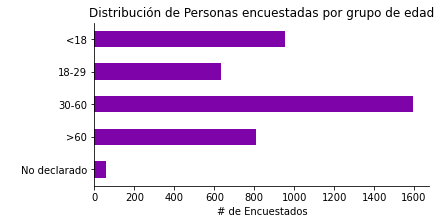

In [ ]:
order = ['<18', '18-29', '30-60','>60','No declarado']
ax = (personas_df.groupby(['age_cohort']).size().loc[reversed(order)]
 .plot(kind='barh', figsize=(6,3)))
ax.set_xlabel("# de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas por grupo de edad")
sns.despine()

La mayor parte de los encuestados tienen entre 30-60 años de edad.

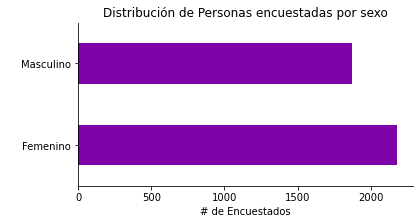

In [ ]:
ax = (personas_df.groupby(['sexo']).size()
 .plot(kind='barh', figsize=(6,3)))
ax.set_xlabel("# de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas por sexo")
sns.despine()

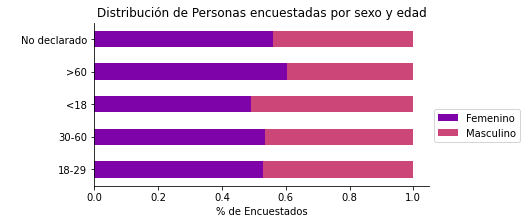

In [ ]:
ax = (personas_df.groupby(['age_cohort', 'sexo']).size().unstack()
 .pipe(normalize_rows)
 .plot(kind='barh', stacked=True, figsize=(6, 3)))
ax.set_xlabel("% de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas por sexo y edad")
sns.despine()

plt.legend(loc=0, bbox_to_anchor=(1.0, 0.5))

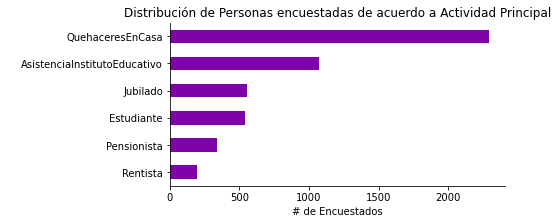

In [ ]:
ax = personas_df[['AsistenciaInstitutoEducativo', 'Jubilado', 'Pensionista', 'Rentista',
       'Estudiante', 'QuehaceresEnCasa']].replace(2,0).T.sum(axis=1).sort_values().plot(kind='barh', figsize=(6,3))
ax.set_xlabel("# de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas de acuerdo a Actividad Principal")
sns.despine()

Vemos que la mayor parte de los encuestados son en su mayoria encargados de quehaceres del hogar, con edades entre 30 y 60 años, con una cantidad equilibrada de hombres y mujeres.

### Parte I: Indicadores de Cantidad de Viajes
En esta primera parte, responderemos algunas preguntas respecto a indicadores de cantidades de viajes realizados, en días hábiles de viaje. Para esto, buscaremos responder las siguientes preguntas:

1. ¿Cuál es la tasa promedio de viajes diarios en transporte público por clasificador económico?
2. ¿Cuál es la tasa promedio de viajes diarios en transporte privado por clasificador económico?
3. ¿Cuál es la razón entre los viajes en transporte público y privado por clasificador socioeconómico?
4. ¿Cuál es la distribución/partición modal de los viajes por clasificador socioeconómico?

En esta sección, se detallarán los resultados para indicadores a nivel de viajes, separados por días hábiles de viaje, y por clasificador socioeconómico.

In [ ]:
print('Cantidad de viajes mapeados: totales encuesta , total expandido')
viajes_habiles = viajes_personas
viajes_habiles = viajes_habiles.drop('EncuestaHogar_ID', axis=1)
print('Total Viajes Habiles: {}'.format(viajes_habiles.shape[0]), viajes_habiles['Ponderacion_x'].sum())


Cantidad de viajes mapeados: totales encuesta , total expandido
Total Viajes Habiles: 8498 4262972.002677735


Separamos los viajes habiles y no habiles de acuerdo a si son privados o publicos

In [ ]:
viajes_publico_habiles = viajes_habiles[viajes_habiles.MEDIOTRANSPORTE.isin(publico_viaje)]
#viajes_publico_nohabiles = viajes_nohabiles[viajes_nohabiles.MEDIO_PREDOMINANTE.isin(publico_viaje)]

viajes_privado_habiles = viajes_habiles[viajes_habiles.MEDIOTRANSPORTE.isin(privado_viaje)]
#viajes_privado_nohabiles = viajes_nohabiles[viajes_nohabiles.MEDIO_PREDOMINANTE.isin(privado_viaje)]

In [ ]:
def weighted_mean(df, value_column, weighs_column):
    weighted_sum = (df[value_column] * df[weighs_column]).sum()
    return weighted_sum / df[weighs_column].sum()

In [ ]:
def weighted_median(df, val, weight):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted[weight].cumsum()
    cutoff = df_sorted[weight].sum() / 2.
    return df_sorted[cumsum >= cutoff][val].iloc[0]

#### **¿Cuál es la tasa promedio de viajes diarios en transporte público por clasificador económico?**

Los siguientes gráficos muestran los viajes per cápita en trasporte público durante días hábiles, por clasificador socioeconómico.

In [ ]:
from pandasql import sqldf
def calculate_n_viajes_per_capita(df, df_str, agg_columns_str, agg_columns_lst, id_person, person_weight, trip_weight=None):
    q = "SELECT DISTINCT {}, {}, {} FROM {}".format(id_person, agg_columns_str, person_weight, df_str)
    persons = sqldf(q, globals())
    n_personas = persons.groupby(agg_columns_lst).sum()[[person_weight]].reset_index()
    n_personas[agg_columns_lst[0]] = n_personas[agg_columns_lst[0]].astype(str)
    n_viajes = df.groupby(agg_columns_lst).sum()[[trip_weight]].reset_index()
    n_viajes[agg_columns_lst[0]] = n_viajes[agg_columns_lst[0]].astype(str)
    merged = pd.merge(n_personas, n_viajes, on=agg_columns_lst, how='left')
    merged['viajes_per_capita'] = merged[trip_weight] / merged[person_weight]
    return merged

Viajes per cápita en transporte público


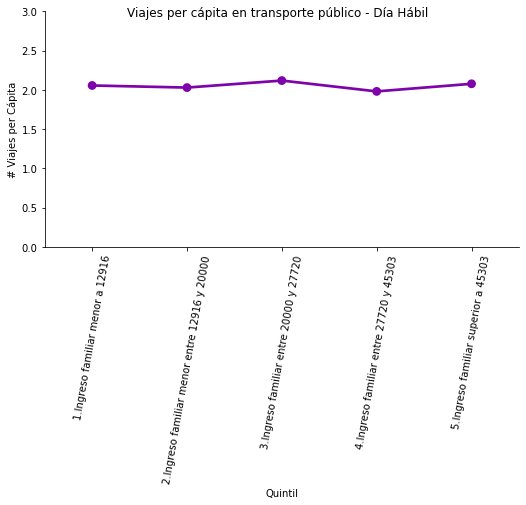

In [ ]:
print('Viajes per cápita en transporte público')
df = calculate_n_viajes_per_capita(viajes_publico_habiles, "viajes_publico_habiles", "Quintil", ["Quintil"], 'EncuestaPersona_id', 'Ponderacion_y', 'Ponderacion_x')
g = sns.catplot(x="Quintil", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte público - Día Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Quintil')
g.set_xticklabels(rotation=80)
g.set(ylim=(0,3))

#fig.tight_layout()


#### **¿Cuál es la tasa promedio de viajes diarios en transporte privado por clasificador económico?**

Los siguientes gráficos representan la tasa promedio de viajes diarios en el transporte privado durante días hábiles, por clasificador socioeconómico.

Viajes per cápita en transporte privado


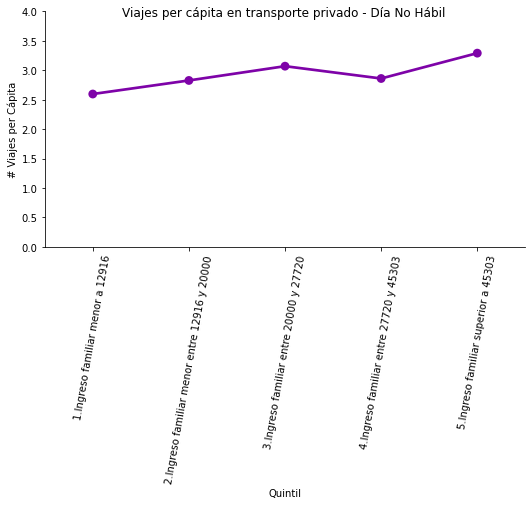

In [ ]:
print('Viajes per cápita en transporte privado')
df = calculate_n_viajes_per_capita(viajes_privado_habiles, "viajes_privado_habiles", "Quintil", ["Quintil"], 'EncuestaPersona_id', 'Ponderacion_y', 'Ponderacion_x')
g = sns.catplot(x="Quintil", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte privado - Día No Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Quintil')
g.set_xticklabels(rotation=80)
g.set(ylim=(0,4))

#fig.tight_layout()

Para días hábiles, no se ve diferencia a través de la clasificación socioeconómica. En transporte privado, se ve una tendencia similar, con un aumento en el 5to clasificador.

#### **¿Cuál es la razón entre los viajes en transporte público y privado por clasificador socioeconómico?**

Los gráficos a continuación muestran la razón entre los viajes en transporte público y transporte privado durante días hábiles, por clasificador socioeconómico.


Razón entre los viajes en transporte público y privado - Día Hábil


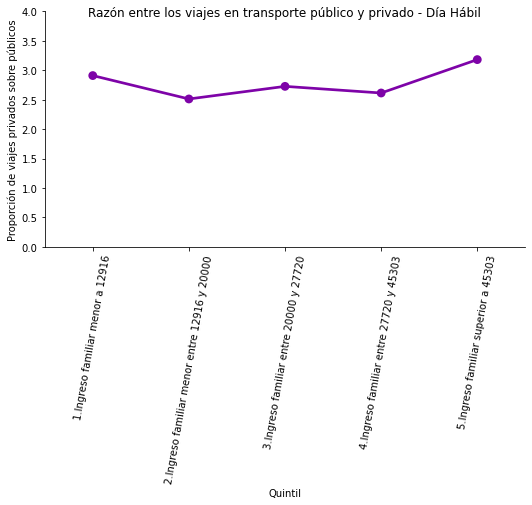

In [ ]:
print('Razón entre los viajes en transporte público y privado - Día Hábil')

viajes_privados = viajes_privado_habiles.groupby(["Quintil"]).agg(n_privados= ('Ponderacion_x', 'sum')).reset_index()
viajes_publicos = viajes_publico_habiles.groupby(["Quintil"]).agg(n_publicos = ('Ponderacion_x', 'sum')).reset_index()
n_viajes_modo = pd.merge(viajes_privados, viajes_publicos, on='Quintil')#.set_index('CLASIFICACION_SISBEN')
n_viajes_modo['privado_sobre_publico'] = n_viajes_modo['n_privados'] / n_viajes_modo['n_publicos']

g = sns.catplot(x="Quintil", y="privado_sobre_publico",
                capsize=.2, height=4, aspect=2,
                kind="point", data=n_viajes_modo)

g.fig.suptitle('Razón entre los viajes en transporte público y privado - Día Hábil')
g.set_ylabels('Proporción de viajes privados sobre públicos')
g.set_xticklabels(rotation=80)
g.set_xlabels('Quintil')
g.set(ylim=(0,4))

#fig.tight_layout()

Podemos notar que a mayor ingreso, mayor es el uso de viajes en transporte privado por sobre el público.

#### **¿Cuál es la distribución/partición modal de los viajes por clasificador socioeconómico?**

Las siguientes tablas y gráficos representan la partición modal de los viajes realizados en días hábiles, por clasificador socioeconómico.

Partición Modal de los Viajes


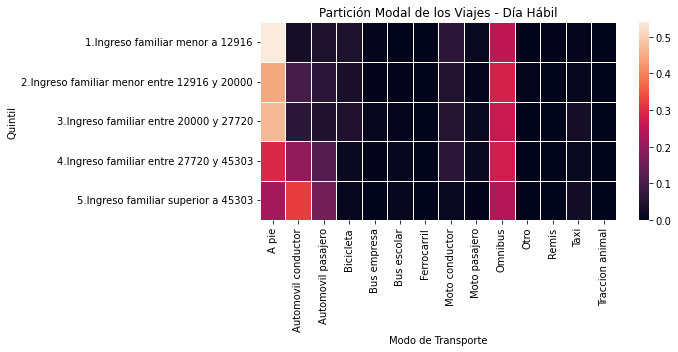

In [ ]:
print('Partición Modal de los Viajes')
df = viajes_habiles.groupby(["Quintil", 'MEDIOTRANSPORTE']).sum()['Ponderacion_x'].unstack()
#.agg(count=('MEDIO_PREDOMINANTE','count')).unstack()
df_norm = df.div(df.sum(axis=1), axis=0).fillna(0)

fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.heatmap(df_norm,linewidth=0.5)

ax.set_title("Partición Modal de los Viajes - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Quintil")

fig.tight_layout()

A continuación, se representa la partición modal de los viajes por tipo de transporte en días hábiles, por quintiles de ingreso de acuerdo a quintiles.

Partición Modal de los Viajes de acuerdo al tipo de transporte


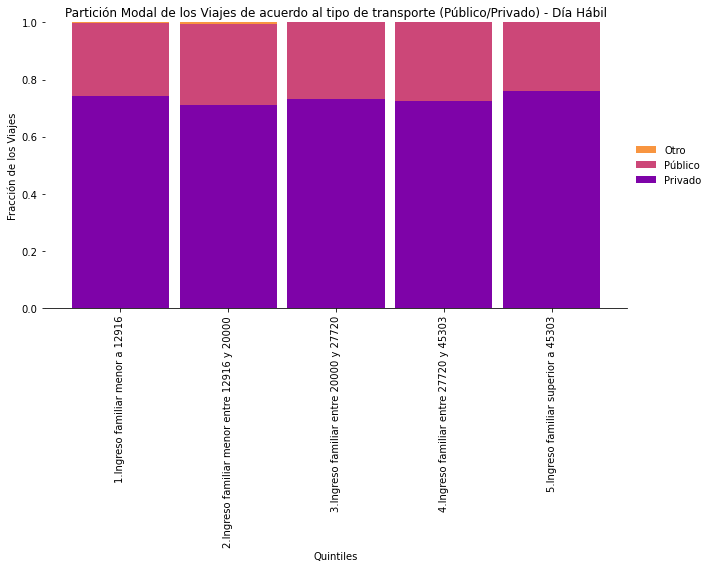

In [ ]:
print('Partición Modal de los Viajes de acuerdo al tipo de transporte')
df = viajes_habiles.groupby(["Quintil", 'publico_privado']).sum()['Ponderacion_x'].unstack()
df_norm= df.div(df.sum(axis=1), axis=0).fillna(0)
from aves.visualization.tables import barchart

fig, ax = plt.subplots(figsize=(10,8))

barchart(
    ax, df_norm, stacked=True, normalize=False, sort_categories=True, sort_items=False
)

ax.set_title("Partición Modal de los Viajes de acuerdo al tipo de transporte (Público/Privado) - Día Hábil")
ax.set_ylim([0, 1])
ax.set_xlabel("Quintiles")
ax.set_ylabel("Fracción de los Viajes")

fig.tight_layout()

Partición Modal de los Viajes de acuerdo al tipo de transporte (Motorizado/No Motorizado) - Día Hábil


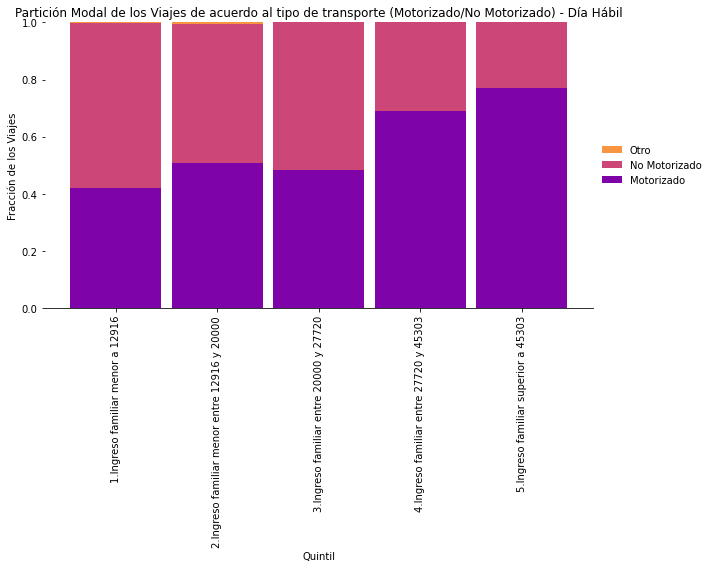

In [ ]:
print('Partición Modal de los Viajes de acuerdo al tipo de transporte (Motorizado/No Motorizado) - Día Hábil')
df = viajes_habiles.groupby(["Quintil", 'motorizado']).sum()['Ponderacion_x'].unstack()
df_norm = df.div(df.sum(axis=1), axis=0)
fig, ax = plt.subplots(figsize=(10, 8))

barchart(
    ax, df_norm, stacked=True, normalize=False, sort_categories=True, sort_items=False
)

ax.set_title("Partición Modal de los Viajes de acuerdo al tipo de transporte (Motorizado/No Motorizado) - Día Hábil")
ax.set_ylim([0, 1])
ax.set_xlabel("Quintil")
ax.set_ylabel("Fracción de los Viajes")

fig.tight_layout()

Se puede notar que al aumentar el ingreso familiar, aumenta el uso de modos motorizados de transporte.

### Parte II: Indicadores de Tiempo de Viajes

En esta primera parte, responderemos algunas preguntas respecto a indicadores de tiempo de viajes realizados, en días hábiles y no hábiles de viaje. Para esto, buscaremos responder las siguientes preguntas:
1. ¿Cuál es el tiempo promedio de viaje por modo y tipo de transporte?
2. ¿Cuál es el tiempo promedio de viaje en hora punta de mañana?
3. ¿Cuál es el tiempo de viaje en transporte público en hora punta de mañana?
4. ¿Cuál es el tiempo promedio de viaje al trabajo en transporte público?

En esta sección, se presentarán los indicadores de tiempo de viajes a nivel de viajes, durante días hábiles, y por clasificador socioeconómico.

#### **¿Cuál es el tiempo promedio de viaje por modo y tipo de transporte?**

A continuación, se representa el promedio y mediana en minutos de viaje por modo y tipo de transporte en días hábiles, por clasificador socioeconómico.

Duración promedio (en minutos) de viaje por modo - Dia Hábil


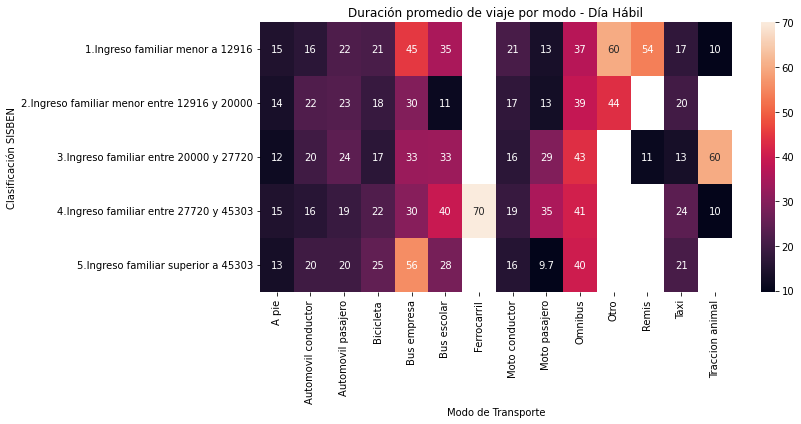

In [ ]:
print('Duración promedio (en minutos) de viaje por modo - Dia Hábil')
df = viajes_habiles.groupby(["Quintil", 'MEDIOTRANSPORTE']).apply(lambda x: weighted_mean(x, 'TiempoTotal', 'Ponderacion_x')).unstack()
fig, ax = plt.subplots(figsize=(12, 6))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Quintil")

fig.tight_layout()

Duración mediana (en minutos) de viaje por modo - Dia Hábil


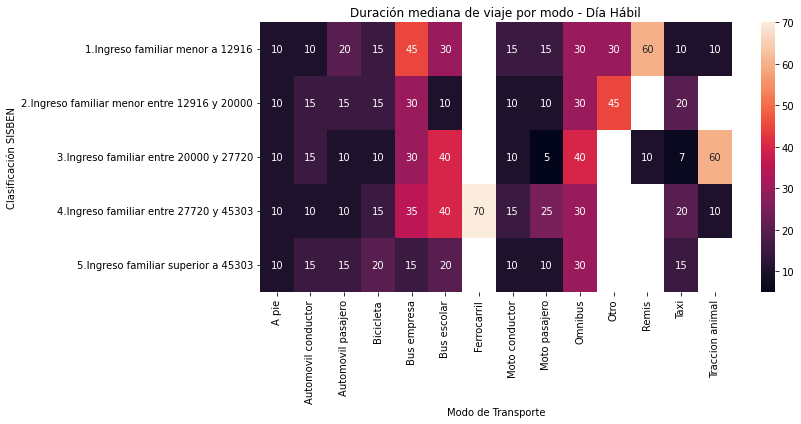

In [ ]:
print('Duración mediana (en minutos) de viaje por modo - Dia Hábil')
df = viajes_habiles.groupby(["Quintil",  'MEDIOTRANSPORTE']).apply(lambda x: weighted_median(x, 'TiempoTotal', 'Ponderacion_x')).unstack()
fig, ax = plt.subplots(figsize=(12,6))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Quintil")

fig.tight_layout()

Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil


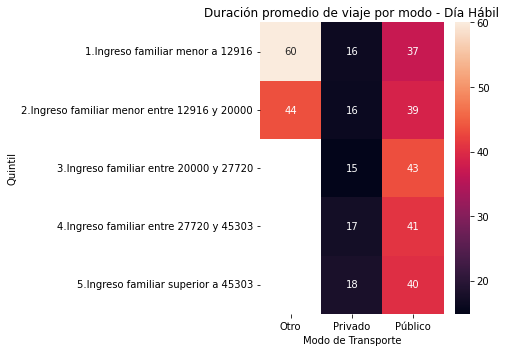

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["Quintil", 'publico_privado']).apply(lambda x: weighted_mean(x, 'TiempoTotal', 'Ponderacion_x')).unstack()
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Quintil")

fig.tight_layout()

Duración mediana (en minutos) de viaje por tipo de transporte - Dia Hábil


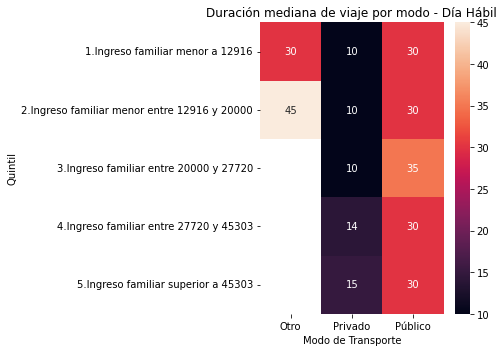

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["Quintil", 'publico_privado']).apply(lambda x: weighted_median(x, 'TiempoTotal', 'Ponderacion_x')).unstack()
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Quintil")

fig.tight_layout()

Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil


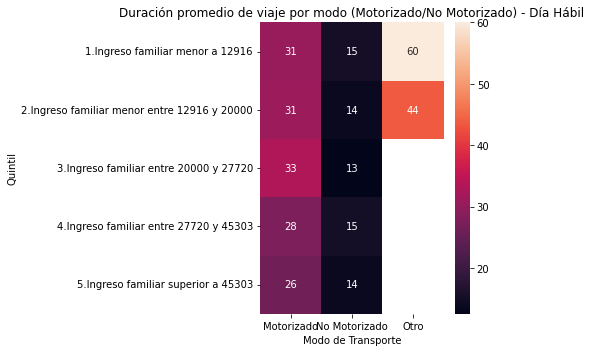

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["Quintil", 'motorizado']).apply(lambda x: weighted_mean(x, 'TiempoTotal', 'Ponderacion_x')).unstack()
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo (Motorizado/No Motorizado) - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Quintil")

fig.tight_layout()

Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil


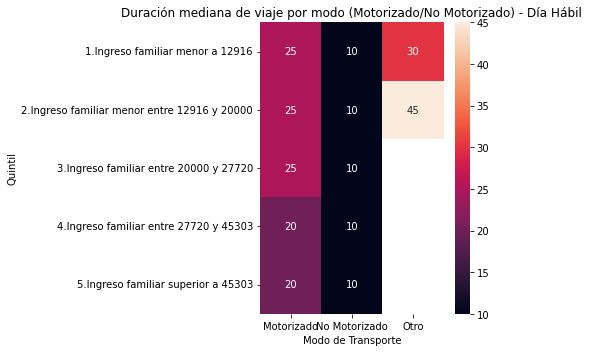

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["Quintil", 'motorizado']).apply(lambda x: weighted_median(x, 'TiempoTotal', 'Ponderacion_x')).unstack()
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo (Motorizado/No Motorizado) - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Quintil")

fig.tight_layout()

#### **¿Cuál es el tiempo promedio de viaje en hora punta de mañana?**

Estos son los resultados para el promedio y mediana en minutos de viaje en hora punta de la mañana por modo de transporte, en días hábiles, por clasificador socioeconómico.

Duración promedio (en minutos) de viaje por modo en hora punta - Dia Hábil


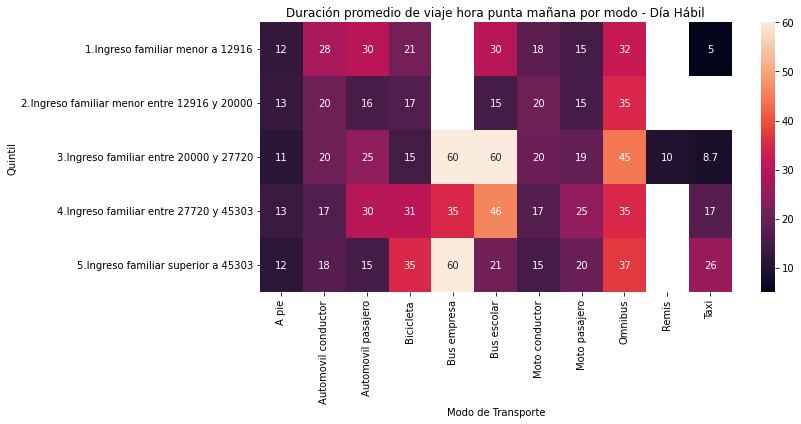

In [ ]:
print('Duración promedio (en minutos) de viaje por modo en hora punta - Dia Hábil')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'].groupby(["Quintil", 'MEDIOTRANSPORTE']).apply(lambda x: weighted_mean(x, 'TiempoTotal', 'Ponderacion_x')).unstack()
fig, ax = plt.subplots(figsize=(12,6))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje hora punta mañana por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Quintil")

fig.tight_layout()

Duración mediana (en minutos) de viaje por modo en hora punta - Dia Hábil


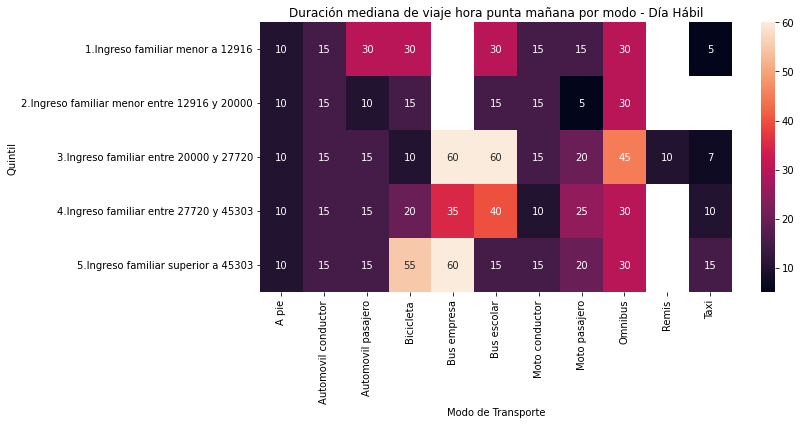

In [ ]:
print('Duración mediana (en minutos) de viaje por modo en hora punta - Dia Hábil')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'].groupby(["Quintil", 'MEDIOTRANSPORTE']).apply(lambda x: weighted_median(x, 'TiempoTotal', 'Ponderacion_x')).unstack()
fig, ax = plt.subplots(figsize=(12,6))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje hora punta mañana por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Quintil")

fig.tight_layout()

Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


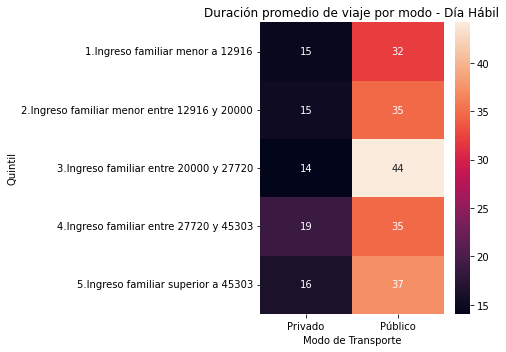

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(["Quintil", 'publico_privado']).apply(lambda x: weighted_mean(x, 'TiempoTotal', 'Ponderacion_x')).unstack()
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Quintil")

fig.tight_layout()

Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


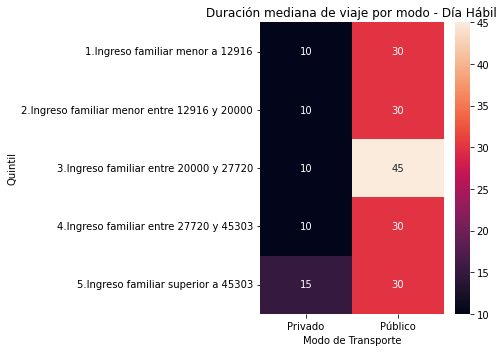

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(["Quintil", 'publico_privado']).apply(lambda x: weighted_median(x, 'TiempoTotal', 'Ponderacion_x')).unstack()
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Quintil")

fig.tight_layout()

#### **¿Cuál es el tiempo de viaje en transporte público en hora punta de mañana?**

A continuación, se presentan los resultados para duración promedio de viaje en hora punta de mañana en transporte público, en días hábiles, por clasificador socioeconómico.

Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil


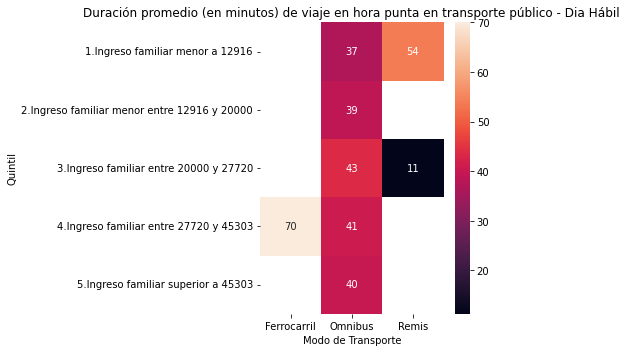

In [ ]:
print('Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público')
df = viajes_habiles[mask].groupby(["Quintil", 'MEDIOTRANSPORTE']).apply(lambda x: weighted_mean(x, 'TiempoTotal', 'Ponderacion_x')).unstack()
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio (en minutos) de viaje en hora punta en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Quintil")

fig.tight_layout()

Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil


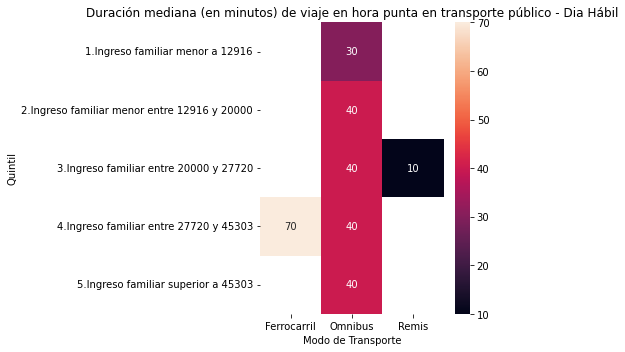

In [ ]:
print('Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público') & (viajes_habiles.NombreActividadDestino=='Trabajo')
df = viajes_habiles[mask].groupby(["Quintil", 'MEDIOTRANSPORTE']).apply(lambda x: weighted_median(x, 'TiempoTotal', 'Ponderacion_x')).unstack()
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana (en minutos) de viaje en hora punta en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Quintil")

fig.tight_layout()

#### **¿Cuál es el tiempo promedio de viaje al trabajo en transporte público?**

A continuación, se presentan los resultados de tiempo promedio de viaje al trabajo en transporte público por modo en días hábiles, por clasificador socioeconómico.

In [ ]:
viajes_habiles.NombreActividadDestino.unique()

array(['Entretenimiento', 'Hogar', 'Compras', 'Trabajo', 'Estudio',
       'Tramites de trabajo', 'Dejar/Recoger ninos del colegio',
       'Acompanar a alguien', 'Tramites personales',
       'Dejar/Recoger a alguien', 'Asistencia medica/dental',
       'Visitar a alguien', 'Ir a comer', 'Otro'], dtype=object)

Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil


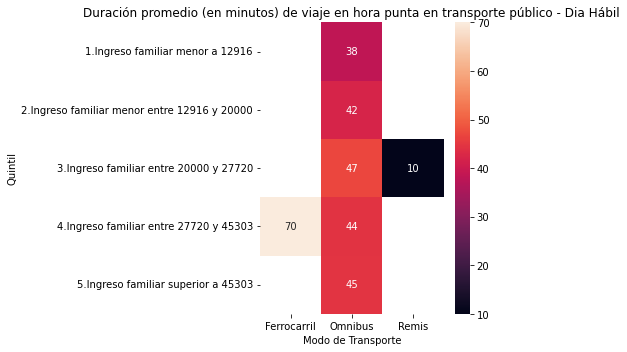

In [ ]:
print('Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público') & (viajes_habiles.NombreActividadDestino=='Trabajo')
df = viajes_habiles[mask].groupby(["Quintil", 'MEDIOTRANSPORTE']).apply(lambda x: weighted_mean(x, 'TiempoTotal', 'Ponderacion_x')).unstack()
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio (en minutos) de viaje en hora punta en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Quintil")

fig.tight_layout()

Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil


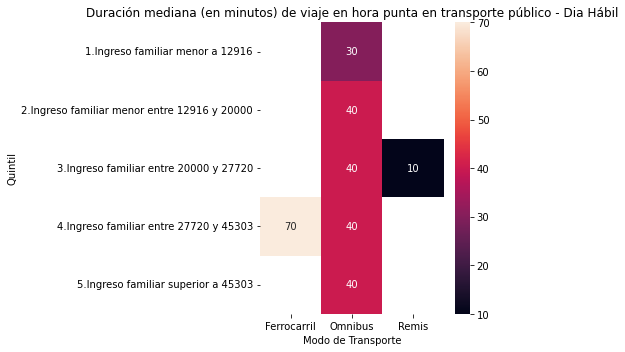

In [ ]:
print('Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público') & (viajes_habiles.NombreActividadDestino=='Trabajo')
df = viajes_habiles[mask].groupby(["Quintil", 'MEDIOTRANSPORTE']).apply(lambda x: weighted_median(x, 'TiempoTotal', 'Ponderacion_x')).unstack()
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana (en minutos) de viaje en hora punta en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Quintil")

fig.tight_layout()